# Trabajo Práctico Número 2 - Procesamiento de Señales, Fundamentos

## DFT - Ejercicio I
Graﬁque las siguientes señales lado a lado con su respectivo espectro en frecuencias:  1) Senoidal. 2) Cuadrada. 3) Triangular 4) Delta en t=0. Indicando en cada caso los siguientes parámetros (si corresponde) : 1) Frecuencia. B) Amplitud. C) Potencia promedio. D) Fs. E) N. 5) Pegue el link a un pdf con los códigos, gráficos y comentarios.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from enum import Enum, auto
from copy import deepcopy as cpy
from dataclasses import dataclass, field

@dataclass
class PsfWaveformSpec:
  fo_hz: float
  fs_hz: float
  samples_n: int
  ph_rad: float = 0
  amp: float = 1

@dataclass
class PsfWaveformData(PsfWaveformSpec):
  power_time: float = 0
  power_freq: float = 0


# Waveform Generators.
def psf_sine(spec: PsfWaveformSpec):
  amp = 0 if spec.amp < 0 else 1 if spec.amp > 1 else spec.amp
  n = np.arange(spec.samples_n) 
  return amp * np.sin((2 * np.pi * spec.fo_hz * n / spec.fs_hz) + spec.ph_rad)

def psf_square(spec: PsfWaveformSpec):
  amp = 0 if spec.amp < 0 else 1 if spec.amp > 1 else spec.amp
  n = np.arange(spec.samples_n) 
  return amp * signal.square(2 * np.pi * spec.fo_hz * n / spec.fs_hz + + spec.ph_rad, .5) 
  
def psf_tri(spec: PsfWaveformSpec):
  amp = 0 if spec.amp < 0 else 1 if spec.amp > 1 else spec.amp
  n = np.arange(spec.samples_n) 
  return amp * signal.sawtooth(2 * np.pi * spec.fo_hz * n / spec.fs_hz + + spec.ph_rad, .5) 

def psf_delta(spec: PsfWaveformSpec):
  amp = 0 if spec.amp < 0 else 1 if spec.amp > 1 else spec.amp
  sn = np.zeros(spec.samples_n) 
  sn[0] = 1.0
  return sn



# Utilities.
def psf_spec_to_time_sec(spec: PsfWaveformSpec):
  return np.arange(spec.samples_n) * 1/spec.fs_hz

def psf_gen_cont_and_disc_wvfm(spec: PsfWaveformSpec, fun=psf_sine):
  spec_cont = cpy(spec)
  spec_cont.fs_hz = spec_cont.fs_hz * 100
  spec_cont.samples_n = spec_cont.samples_n * 100
  return (psf_spec_to_time_sec(spec), fun(spec)), (psf_spec_to_time_sec(spec_cont), fun(spec_cont))  

def easy_fft(x, fs):
    fft = np.abs(np.fft.fftshift(np.fft.fft(x)/len(x)))
    fft_fs = np.fft.fftshift(np.fft.fftfreq(len(x), 1/fs))
    return fft, fft_fs

def get_avg_power_f(X):
  return np.sum(abs(X)**2)

def get_avg_power_t(x):
  return np.sum(x**2) / len(x)


font = {'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)

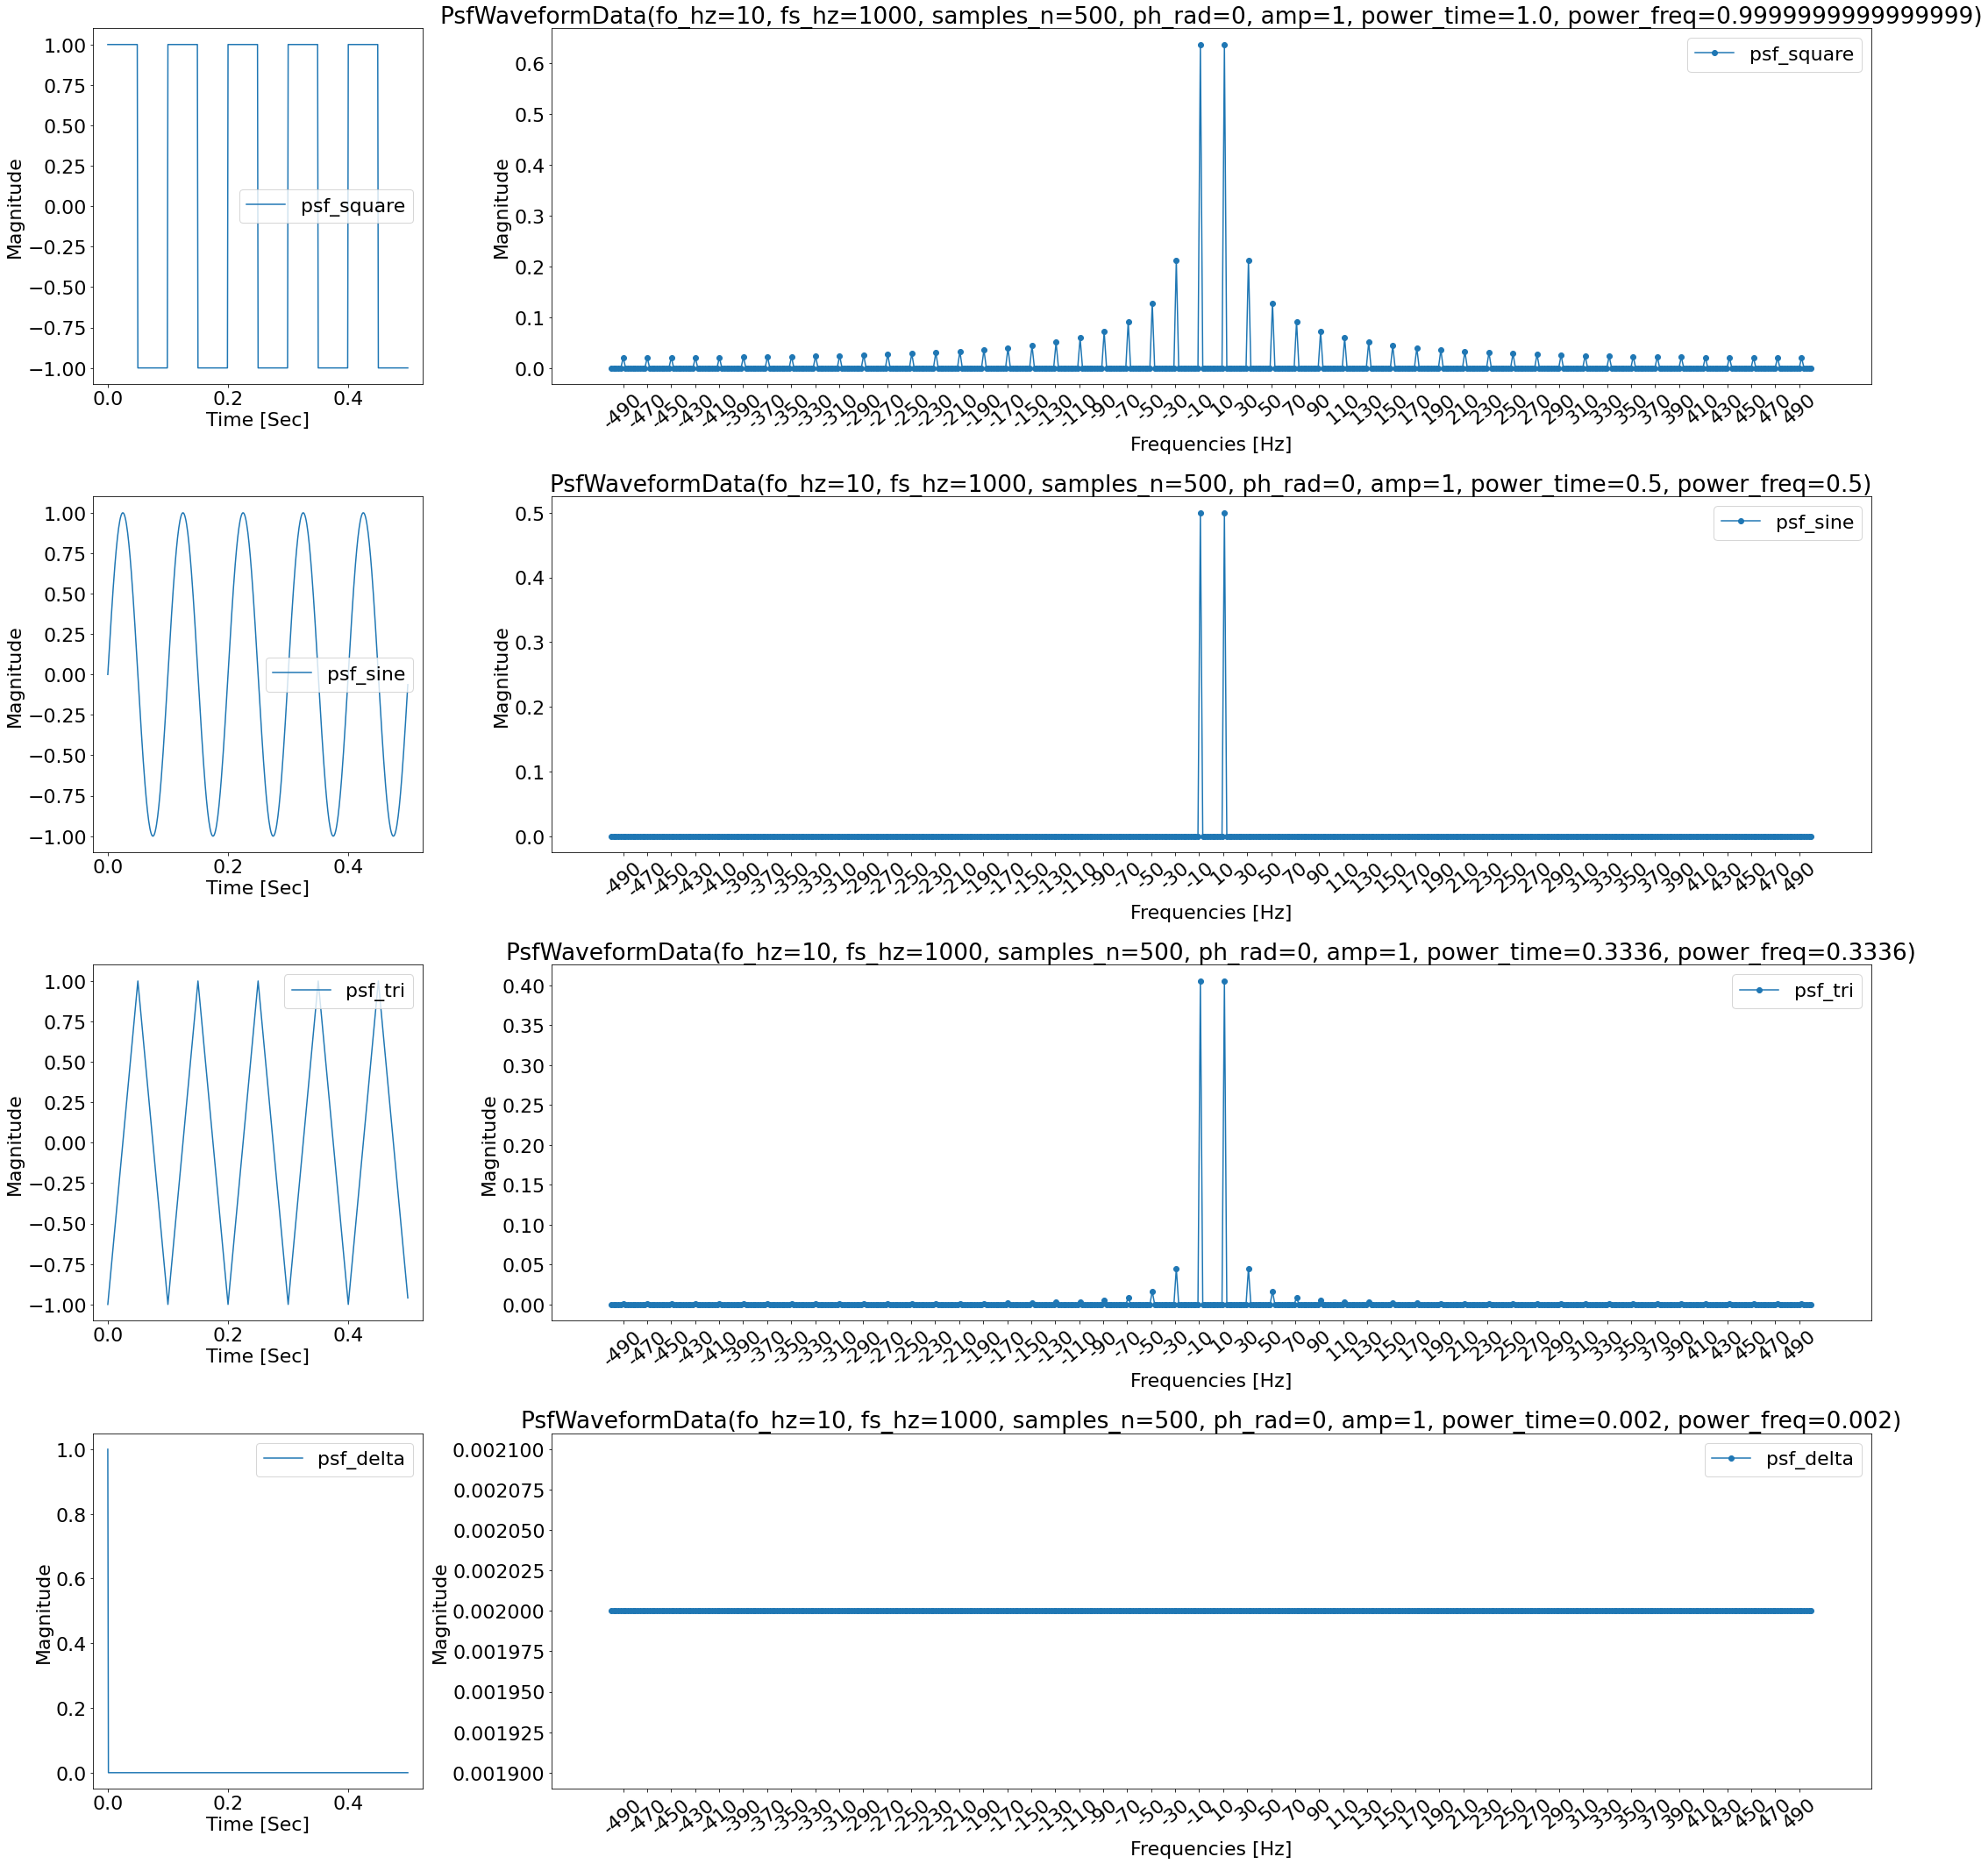

In [34]:
def get_avg_power(spectrum):
  return np.sqrt(np.sum(spectrum**2))



font = {'weight' : 'normal',
        'size'   : 22}

plt.rc('font', **font)

wfm = PsfWaveformSpec(
    fo_hz = 10,
    fs_hz = 1000,
    samples_n = 500,
    ph_rad = 0,
    amp = 1
)

waveforms = (psf_square, psf_sine, psf_tri, psf_delta)

fig, axs = plt.subplots(len(waveforms), 2 , figsize=(30, 30), gridspec_kw={'width_ratios': [1, 4]})


for i, fun in enumerate((psf_square, psf_sine, psf_tri, psf_delta)):
  time = np.arange(0, wfm.samples_n) * 1/wfm.fs_hz
  sig = fun(wfm)
  fft, fft_fs = easy_fft(sig, wfm.fs_hz)
  fft = np.abs(np.fft.fftshift(np.fft.fft(sig)/len(sig)))
  fft_fs = np.linspace(-wfm.fs_hz / 2, wfm.fs_hz / 2, wfm.samples_n)
  
  d = PsfWaveformData(power_freq=get_avg_power_f(fft), power_time=get_avg_power_t(sig),  **wfm.__dict__)
  axs[i, 0].plot(time, sig, label=fun.__name__)
  axs[i, 0].legend()
  axs[i, 0].set_xlabel('Time [Sec]')
  axs[i, 0].set_ylabel('Magnitude')
  axs[i, 1].set_title(str(d))
  axs[i, 1].plot(fft_fs, fft, '-o', label=fun.__name__)
  axs[i, 1].legend()
  axs[i, 1].set_xlabel('Frequencies [Hz]')
  axs[i, 1].set_ylabel('Magnitude')
  axs[i, 1].set_xticks(range(-490, 500, 20))
  axs[i, 1].set_xticklabels(range(-490, 500, 20), rotation=40)

plt.tight_layout()
plt.show()


## DFT - Ejercicio I - Comentarios
Se puede observar que:

* El espectro de la señal cuadrada cuenta con contenido armónico múltiplo de la
frecuencia original, pero con armonicos _páres_ nulos. 

* El espectro de la señal triángular es similar a la cuadrada, pero la 
atenucación de cada armónico subsiguiente es aún mayor (cuadrática inversa).

* El espectro de la señal senoidal consiste de únicamente un pico de frecuencia,
con su contraparte en frecuencias negativas.

* El espectro de la delta es constante. Cabe destacar que el valor de dicha 
constante es tal que su *energía* total en el espectro es igual a 1. 
Cobra más sentido hablar de energía en este caso, porque no es una señal 
periódica como las anteriores.

## DFT ejercicio II
Dado el archivo clases/tp2/resolucion_espectral.txt  que contiene 100 valores reales sampleados a Fs=200Hz, indique: 1) Resolución espectral. 2) Espectro en frecuencia de la señal. 3) A simple inspección que frecuencia(s) distingue. 4) Aplique alguna técnica que le permita mejorar la resolución espectral y tome nuevamente el espectro. 5) Indique si ahora los resultados difieren del punto 3 y argumente su respuesta. 6) Pegue el link a un pdf con los códigos, gráficos y comentarios.

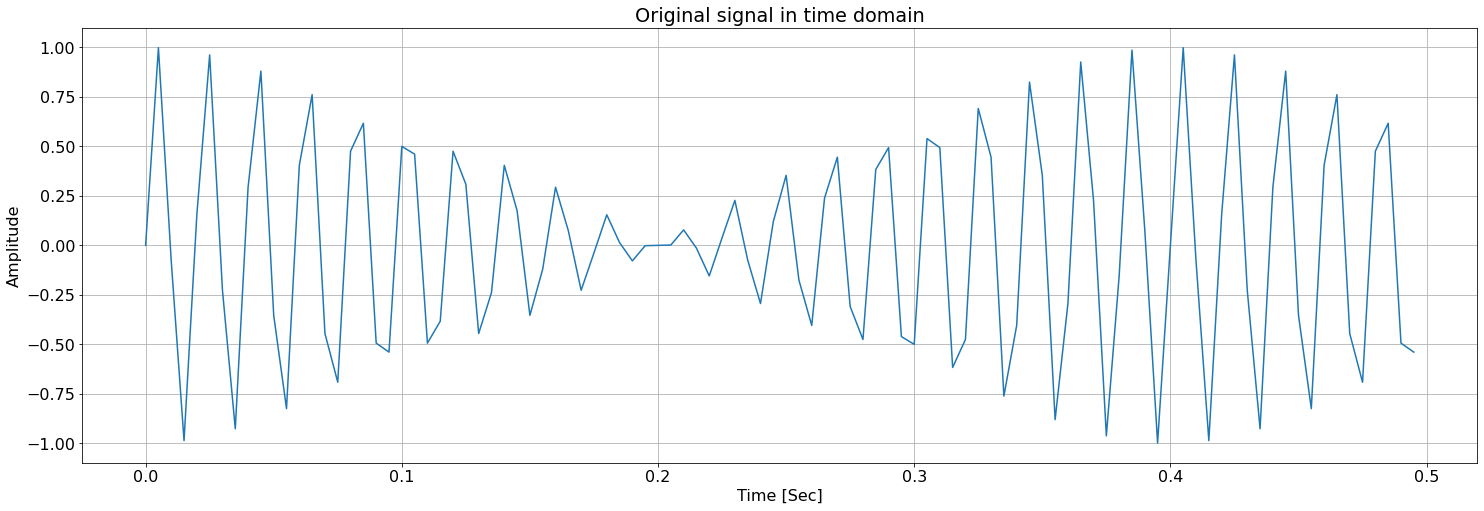

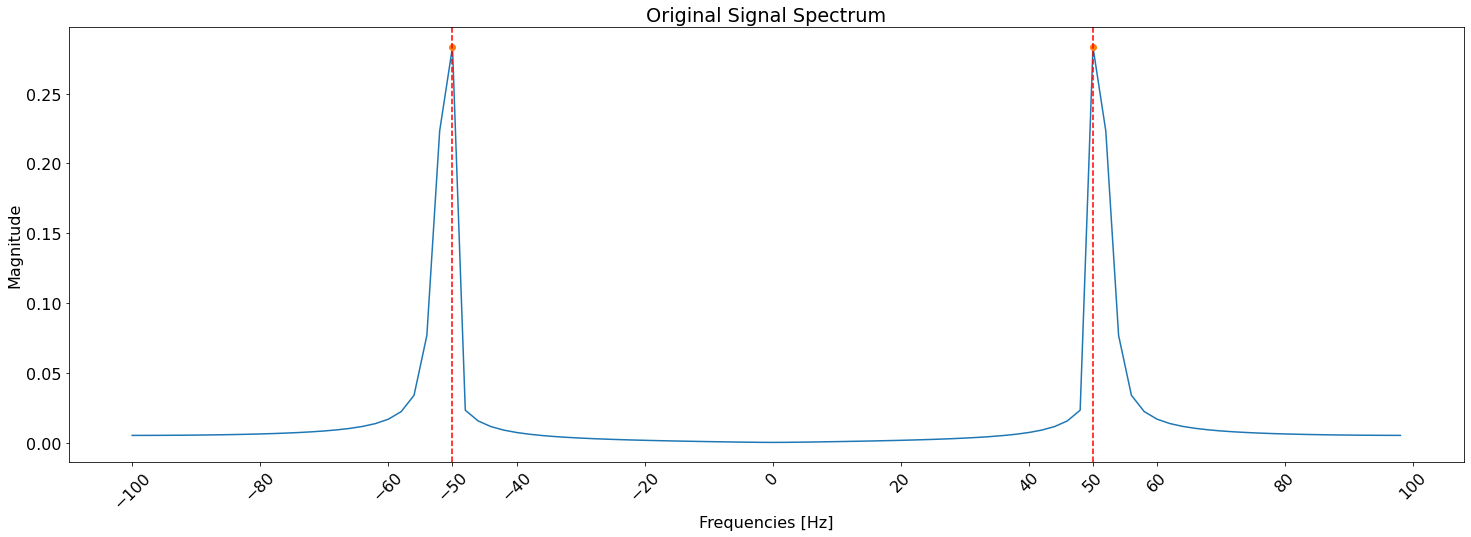

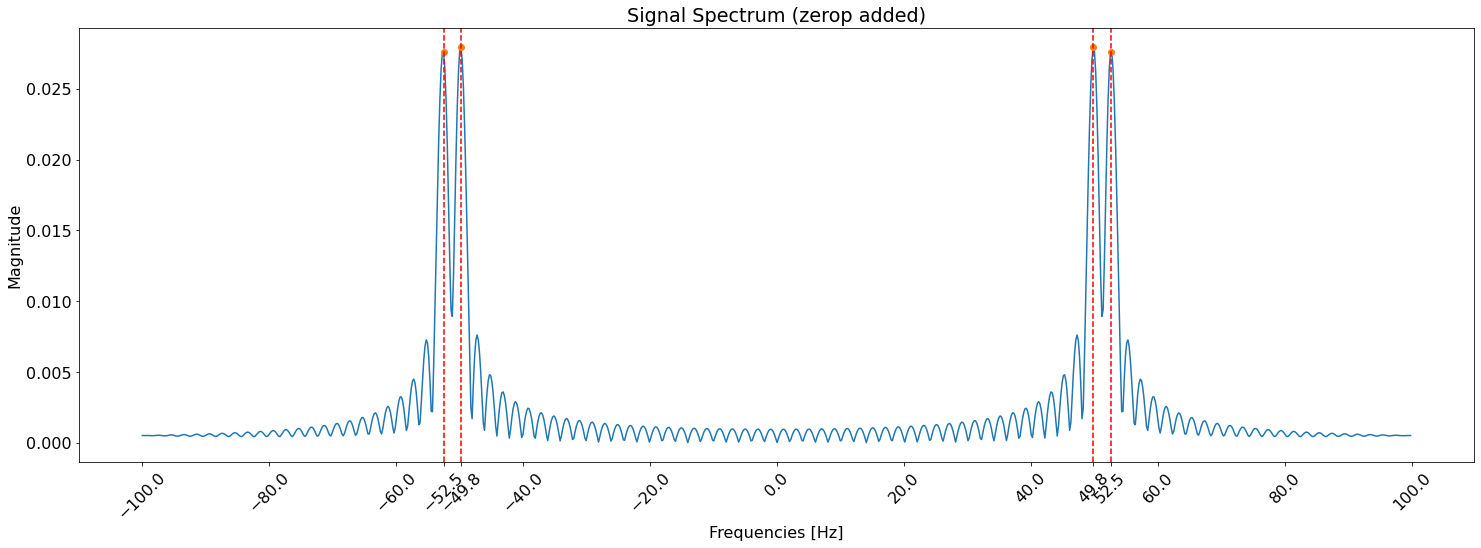

Peaks before padding (Hz): -50.0; 50.0
Peaks after padding (Hz): -52.5390625; -49.8046875; 49.8046875; 52.5390625


In [17]:
import numpy as np
import scipy


font = {'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

# Constants.
FS = 200
PSF_FILE = './data/resolucion_espectral.txt' 
PADDING_SIG_LEN_MULT = 5

# Waveform loading.
with open(PSF_FILE) as f:
    sig = np.array(eval(f.read()))
    time = np.arange(len(sig)) * 1/FS

# Original signal in time domain.
plt.figure(figsize=(25,8))
plt.plot(time, sig)
plt.grid()
plt.ylabel('Amplitude')
plt.xlabel('Time [Sec]')
plt.title('Original signal in time domain')
plt.show()

# Original signal spectrum
## FFT & peak detection.
fft, freqs = easy_fft(sig, FS)
peaks_ind, peaks = scipy.signal.find_peaks(fft, height=0.15)
peaks_fs = [freqs[i] for i in peaks_ind]
peaks_vals = peaks['peak_heights']
# ---
plt.figure(figsize=(25,8))
plt.plot(freqs, fft)
plt.plot(peaks_fs, peaks_vals, 'o')
for f in peaks_fs:
    plt.axvline(x=f, color='r', linestyle='--')
plt.title('Original Signal Spectrum')
plt.xticks(np.concatenate((np.linspace(-100, 100, 11), peaks_fs)), rotation=45)
plt.xlabel('Frequencies [Hz]')
plt.ylabel('Magnitude')
plt.show()


# Signal padded
## FFT & peak detection.
sig_padded = np.concatenate((sig, np.zeros(924)))
fft, freqs = easy_fft(sig_padded, FS)
peaks_ind, peaks = scipy.signal.find_peaks(fft, height=0.02)
peaks_pd_fs = [freqs[i] for i in peaks_ind]
peaks_vals = peaks['peak_heights']
plt.figure(figsize=(25,8))
plt.plot(freqs, fft)
plt.plot(peaks_pd_fs, peaks_vals, 'o')
for f in peaks_pd_fs:
    plt.axvline(x=f, color='r', linestyle='--')
plt.xticks(np.concatenate((np.linspace(-100, 100, 11), peaks_pd_fs)), rotation=45)
plt.xlabel('Frequencies [Hz]')
plt.ylabel('Magnitude')
plt.title('Signal Spectrum (zerop added)')
plt.show()

print(f'Peaks before padding (Hz): ' + '; '.join(map(str, peaks_fs)))
print(f'Peaks after padding (Hz): ' + '; '.join(map(str, peaks_pd_fs)))



## DFT - Ejercicio II - Comentarios
Puede observarse que con la resolución espectral resultante de utilizar
únicamente el número de muestras de la señal original, se pueden distinguir
solo dos picos en +-50 Hz. A priori la asimetría en la envolvente de los picos
permite sospechar que no es un tono puro, pero resulta imposible comprender
exactamente cómo está conformada la señal.

Luego de aplicar la técnica de `Zero Padding` para aumentar la resolución en
frecuencia (a costas de perder SNR) se pueden distinguir claramente dos picos
de frecuencias en 48.9 y 52.5 (con su contrapartida negativa). Esto permite
apreciar de mejor manera que la señal original se trata posiblemente de una
suma de dos tonos de estas frecuencias, y no simplemente un tono o señal de
50Hz.

## IDFT - Ejercicio
En el archivo clases/tp2/ﬀt_hjs.npy se almacenaron los valores de un espectro en frecuencia correspondientes a una señal desconocida. Indique: 1) Puede estimar que representa esta señal? (tip: grafique en 2d la idft) 2) Hasta que punto podría limitar el ancho de banda del espectro dado en el archivo y que aun se logre interpretar la señal? 3) Pegue el link a un pdf con los códigos y los gráficos utilizados.

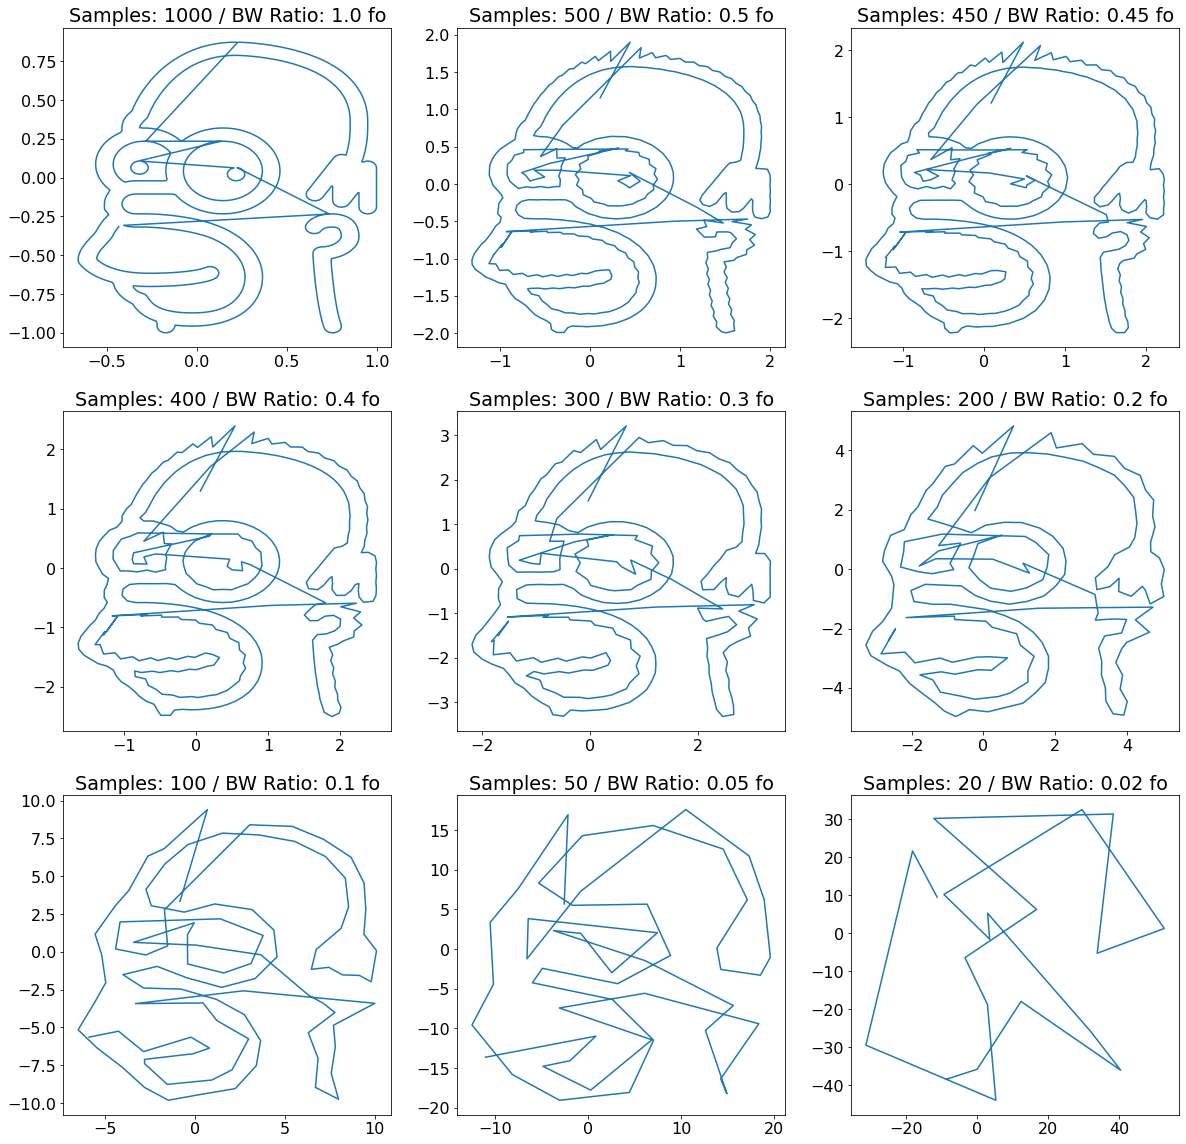

In [18]:
import numpy as np
sig_spectrum = np.load('./data/fft_hjs.npy')

def ifft_2d(x):
    sig = np.fft.ifft(x)
    return (np.imag(sig), np.real(sig))

def spectrum_truncate(x, n):
    return np.concatenate((x[:n], x[len(x)-n:]))
    

test_points =(500, 250, 225, 200, 150, 100, 50, 25, 10)
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
for i in range(3):
    for j in range(3):
        x, y = ifft_2d(spectrum_truncate(sig_spectrum, test_points[3*i + j]))
        axs[i, j].plot(x, y)
        axs[i, j].set_title(f'Samples: {2 * test_points[3*i + j]} / BW Ratio: {test_points[3*i + j] / 500} fo')
plt.show()

## IDFT - Ejercicio - Comentarios
Puede observarse como el Homero Simpson modelado por el espectro de la señal
original se va deformando a medida que se reducen las muestras. Por inspección,
tomando únicamente 200 muestras de las 1000 originales sería suficiente para
reconocer a Homero (y quizás con 100 también).